In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from config import PGHOST, PGDATABASE, PGUSER, PGPASSWORD


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
# Define a function to connect to AWS database instance

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
conn, cursor = connect()

Connected!


In [4]:
# Get the data, read SQL query into data frame
gg_data = pd.read_sql_query("SELECT * FROM google", con=conn)
gg_df = pd.DataFrame(gg_data)
gg_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


In [5]:
# Check the rows and columns of dfs
print(gg_df.shape)

(4553, 7)


In [6]:
# Check if there is null values
gg_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [7]:
# Check the data types in df
gg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4553 non-null   object 
 1   open_price   4553 non-null   float64
 2   high_price   4553 non-null   float64
 3   low_price    4553 non-null   float64
 4   close_price  4553 non-null   float64
 5   adj_close    4553 non-null   float64
 6   volume       4553 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 249.1+ KB


In [8]:
# change the date column data tpye
gg_df['Date'] = pd.to_datetime(gg_df.Date)
# set date as frame index
gg_df.set_index('Date')
# select data after year 2017
gg_df = gg_df.loc[gg_df.Date >='2017-01-01']

gg_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
3115,2017-01-03,40.0310,40.5720,39.8445,40.4005,40.4005,39180000
3116,2017-01-04,40.4945,40.6715,40.2055,40.3885,40.3885,30306000
3117,2017-01-05,40.3750,40.6870,40.2960,40.6510,40.6510,26810000
3118,2017-01-06,40.7495,41.4480,40.5750,41.2605,41.2605,40342000
3119,2017-01-09,41.3185,41.5215,41.0810,41.3590,41.3590,28178000


In [9]:
gg_df = gg_df.drop(['adj_close','volume'], axis=1)

gg_df.head()

,Date,open_price,high_price,low_price,close_price
3115,2017-01-03,40.0310,40.5720,39.8445,40.4005
3116,2017-01-04,40.4945,40.6715,40.2055,40.3885
3117,2017-01-05,40.3750,40.6870,40.2960,40.6510
3118,2017-01-06,40.7495,41.4480,40.5750,41.2605
3119,2017-01-09,41.3185,41.5215,41.0810,41.3590


In [10]:
# Create a date series for plotting purpose
date_train = pd.to_datetime(gg_df['Date'])

date_train.head()

3115   2017-01-03
3116   2017-01-04
3117   2017-01-05
3118   2017-01-06
3119   2017-01-09
Name: Date, dtype: datetime64[ns]

In [11]:
# Select "open, high, low, close" as input features

columns = list(gg_df)[1:5]

print(columns)

['open_price', 'high_price', 'low_price', 'close_price']


In [12]:
# Create a new dataframe with only training data - 4 columns

gg_training_df = gg_df[columns].astype(float)

gg_training_df.head()

,open_price,high_price,low_price,close_price
3115,40.0310,40.5720,39.8445,40.4005
3116,40.4945,40.6715,40.2055,40.3885
3117,40.3750,40.6870,40.2960,40.6510
3118,40.7495,41.4480,40.5750,41.2605
3119,41.3185,41.5215,41.0810,41.3590


In [13]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaled the traing dataset

scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()
scaler = scaler.fit(gg_training_df)
scaled_training_data = scaler.transform(gg_training_df)

print(scaled_training_data.shape)

(1438, 4)


In [14]:
# LSTM require to reshape the input data into (n_samples, timesteps, n_features). 
# This project we choose n_features=4 and timesteps = 30 (past days data used for training). 
# Create empty X_train and y_train list 
X_train = []
y_train = []

training_data_len = round(len(scaled_training_data)*0.8)
# Define future days we want to predict and look-back days used for prediction

look_back = 30 # number of days to be used for prediction
num_future_days = 1 # number of days to be prediced

for i in range(look_back, training_data_len-num_future_days+1):
    X_train.append(scaled_training_data[i-look_back:i, 0:scaled_training_data.shape[1]])
    y_train.append(scaled_training_data[i+num_future_days-1:i+num_future_days, 3])

# Create X_test list

X_test = []

for j in range(training_data_len, len(scaled_training_data)-num_future_days+1):
    X_test.append(scaled_training_data[j-look_back:j, 0:scaled_training_data.shape[1]])

In [15]:
X_train, y_train, X_test = np.array(X_train), np.array(y_train), np.array(X_test)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1120, 30, 4)
(1120, 1)
(288, 30, 4)


In [17]:
# Build the LSTM model

model = Sequential()

# Add two hidden layers
# model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=False))

model.add(LSTM(units=200, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=100, return_sequences=False))
# Add output layer, which contains 1 output
model.add(Dense(units=1))

# Complile the model 
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 200)           164000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 284,501
Trainable params: 284,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the model

model.fit(X_train, y_train, batch_size =128, epochs=10, verbose=1)

Epoch 1/10
9/9 [==============================] - 5s 107ms/step - loss: 0.0192
Epoch 2/10
9/9 [==============================] - 1s 107ms/step - loss: 0.0030
Epoch 3/10
9/9 [==============================] - 1s 107ms/step - loss: 0.0012
Epoch 4/10
9/9 [==============================] - 1s 108ms/step - loss: 6.4847e-04
Epoch 5/10
9/9 [==============================] - 1s 109ms/step - loss: 5.0137e-04
Epoch 6/10
9/9 [==============================] - 1s 105ms/step - loss: 4.3352e-04
Epoch 7/10
9/9 [==============================] - 1s 110ms/step - loss: 4.1133e-04
Epoch 8/10
9/9 [==============================] - 1s 114ms/step - loss: 3.9669e-04
Epoch 9/10
9/9 [==============================] - 1s 108ms/step - loss: 3.9368e-04
Epoch 10/10
9/9 [==============================] - 1s 108ms/step - loss: 3.8588e-04


In [19]:
# Test the model
# Make prediction

prediction = model.predict(X_test)

print(prediction.shape)

9/9 [==============================] - 1s 14ms/step
(288, 1)


In [20]:
#Perform inverse transformation to rescale back to original range
#Since we used 4 variables for transform, the inverse expects same dimensions
#Therefore, we copy our prediction values 4 times and discard them after inverse transform

prediction_copies = np.repeat(prediction, scaled_training_data.shape[1], axis=-1)
print(prediction_copies)

[[0.8278112  0.8278112  0.8278112  0.8278112 ]
 [0.83707005 0.83707005 0.83707005 0.83707005]
 [0.84521043 0.84521043 0.84521043 0.84521043]
 ...
 [0.64119154 0.64119154 0.64119154 0.64119154]
 [0.6351612  0.6351612  0.6351612  0.6351612 ]
 [0.627868   0.627868   0.627868   0.627868  ]]


In [21]:
# Discard the extra columns
y_pred = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred.shape)

(288,)


In [22]:
# Create the y_test data to compare with the predictions

close_df = pd.DataFrame({'Date':gg_df['Date'], 'close_price':gg_training_df['close_price']})
y_test = close_df[training_data_len:]
y_test.head()

,Date,close_price
4265,2021-07-29,135.7775
4266,2021-07-30,134.7265
4267,2021-08-02,134.8545
4268,2021-08-03,135.6300
4269,2021-08-04,135.1255


In [23]:
print(y_test['close_price'].shape)

(288,)


In [24]:
# Calculate the MSE

print(mean_squared_error(y_test['close_price'], y_pred))

29.78063219540571


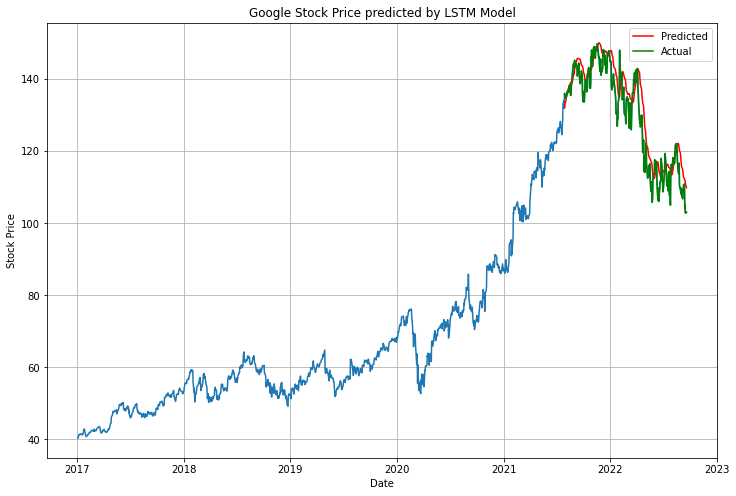

In [25]:
# plot test predictions

plt.figure(figsize=(12, 8))
plt.plot(date_train, gg_training_df['close_price'])
plt.plot(y_test['Date'], y_pred, color='red', label='Predicted')
plt.plot(y_test['Date'], y_test['close_price'], color='green', label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.title("Google Stock Price predicted by LSTM Model")
plt.grid()
plt.legend()
plt.show()